# Hot Plasma II. Sandbox

Play around with some figures for Paper II

In [1]:
#import libraries
import sys
import os
from imp import reload
import pickle

from astroML import density_estimation
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import scipy.optimize

#sns.set_context('notebook',font_scale=1.5)
plt.style.use('papers')
sys.path.append(os.path.join(os.environ['RESEARCH_DIR'],'EBTEL_analysis/src/'))

import em_binner as emb
reload(emb)

%matplotlib inline

## Testing the Variability of EM Slope with Limits 

First, read in the data from a results file.

In [2]:
tn,species,alpha = 5000,'electron','1.5'
total_time,tpulse,loop_length = 80.0e+4,200.0,40.0e+8
run_no = np.random.randint(0,int(np.ceil(1.0e+4/(total_time/(tn+tpulse)))))
file = 'ebtel_L40.0_tn%d_tpulse200.0_rka4/ebtel_L40.0_tn%d_tpulse200.0_rka4_%d.txt'%(tn,tn,run_no)
data = np.loadtxt(os.path.join('/data/datadrive2/EBTEL_runs/%s_heating_runs/alpha%s/data'%(species,alpha),file))
time,temperature,density = data[:,0],data[:,1],data[:,3]
print('Pulling results from %s'%(file))

Pulling results from ebtel_L40.0_tn5000_tpulse200.0_rka4/ebtel_L40.0_tn5000_tpulse200.0_rka4_5.txt


Now, create the emission measure distribution.

In [3]:
binner = emb.EM_Binner(loop_length,time=time,temp=temperature,density=density)

In [4]:
binner.build_em_dist()

Now build the histogram.

In [5]:
em_hist,edges = np.histogram(binner.T_em_flat,weights=binner.em_flat,bins=binner.T_em_histo_bins)
centers = edges[0:-1] + np.diff(edges)/2.0

Next, we want to fit the hot (and cool) side with a power-law and see how the slope changes as our limits change.

In [6]:
#fitting function and parameters
def linear_fit(x,a,b):
    return a*x + b
log_em_threshold = 2
delta_log_t = 0.4
t_hot_min_min = 6.7
t_cool_max_min = 6.1

In [129]:
#calculate hot slopes
temp_sigma,temp_a,temp_x,temp_y = [],[],[],[]
th_min = np.logspace(t_hot_min_min,t_hot_min_min+delta_log_t,1000)
th_max = centers[np.argmax(em_hist):-1][np.where(em_hist[np.argmax(em_hist):-1]<np.max(em_hist)/(10**(log_em_threshold)))[0][0]]#10**7.2
for t in th_min:
    i = np.where((centers >= t) & (centers <= th_max))
    temp = centers[i[0]]
    em = em_hist[i[0]]
    pars,covar = scipy.optimize.curve_fit(linear_fit,np.log10(temp),np.log10(em))
    temp_a.append(pars[0])
    temp_sigma.append(np.sqrt(np.diag(covar))[0])
    temp_x.append(np.array(temp))
    temp_y.append(np.array(linear_fit(np.log10(temp),*pars)))
hot_slopes = {'sigma':temp_sigma,'a':temp_a,'x':temp_x,'y':temp_y}

Fitting the cool side with a similar amount of variability.

In [130]:
#calculate cool slopes
temp_sigma,temp_a,temp_x,temp_y = [],[],[],[]
tc_min = centers[0:np.argmax(em_hist)][np.where(em_hist[0:np.argmax(em_hist)]<np.max(em_hist)/(10**(log_em_threshold)))[0][-1]]#10**6
tc_max = np.logspace(t_cool_max_min,t_cool_max_min+delta_log_t,1000)
for t in tc_max:
    i = np.where((centers >= tc_min) & (centers <= t))
    temp = centers[i[0]]
    em = em_hist[i[0]]
    pars,covar = scipy.optimize.curve_fit(linear_fit,np.log10(temp),np.log10(em))
    temp_a.append(pars[0])
    temp_sigma.append(np.sqrt(np.diag(covar))[0])
    temp_x.append(np.array(temp))
    temp_y.append(np.array(linear_fit(np.log10(temp),*pars)))
cool_slopes = {'sigma':temp_sigma,'a':temp_a,'x':temp_x,'y':temp_y}

Now plot the slope values as function of the lower-limit and all of the fit lines on top of our EM distribution...

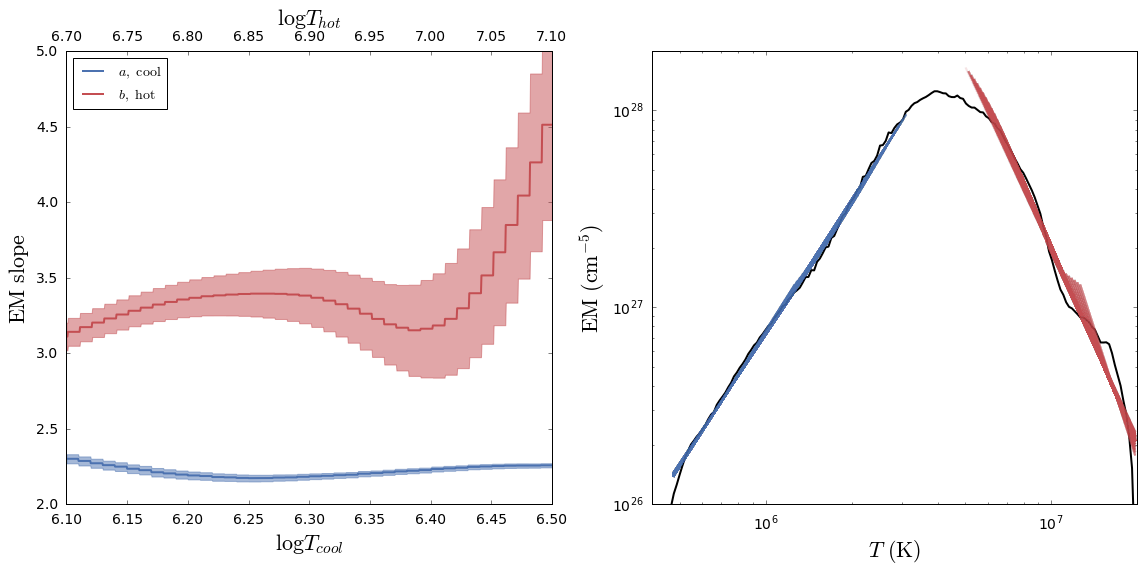

In [131]:
# Plotting EM and slopes
fig,ax = plt.subplots(1,2,figsize=(16,8))
#slope comparison
line_cool = ax[0].plot(np.log10(tc_max),np.fabs(cool_slopes['a']),color=sns.color_palette('deep')[0],label=r'$a,\,\,\mathrm{cool}$')
ax[0].fill_between(np.log10(tc_max),np.fabs(cool_slopes['a'])-np.fabs(cool_slopes['sigma']),
                   np.fabs(cool_slopes['a'])+np.fabs(cool_slopes['sigma']),
                  edgecolor=sns.color_palette('deep')[0],facecolor=sns.color_palette('deep')[0],alpha=0.5)
ax_top = ax[0].twiny()
line_hot = ax_top.plot(np.log10(th_min),np.fabs(hot_slopes['a']),color=sns.color_palette('deep')[2],label=r'$b,\,\,\mathrm{hot}$')
ax_top.fill_between(np.log10(th_min),np.fabs(hot_slopes['a'])-np.fabs(hot_slopes['sigma']),
                   np.fabs(hot_slopes['a'])+np.fabs(hot_slopes['sigma']),
                  edgecolor=sns.color_palette('deep')[2],facecolor=sns.color_palette('deep')[2],alpha=0.5)
ax[0].set_xlabel(r'$\log{T_{cool}}$')
ax_top.set_xlabel(r'$\log{T_{hot}}$')
ax[0].set_ylabel(r'$\mathrm{EM}\,\,\mathrm{slope}$')
ax_top.set_xlim([t_hot_min_min,t_hot_min_min+delta_log_t])
ax[0].set_xlim([t_cool_max_min,t_cool_max_min+delta_log_t])
ax[0].set_ylim([2,5])
#emission measure distribution
ax[1].plot(centers,em_hist,color='k')
for i in range(len(th_min)):
    ax[1].plot(hot_slopes['x'][i],10**(hot_slopes['y'][i]),color=sns.color_palette('deep')[2],alpha=0.05)
for i in range(len(tc_max)):
    ax[1].plot(cool_slopes['x'][i],10**(cool_slopes['y'][i]),color=sns.color_palette('deep')[0],alpha=0.05)
ax[1].set_xlabel(r'$T\,\,(\mathrm{K})$')
ax[1].set_ylabel(r'$\mathrm{EM}\,\,(\mathrm{cm}^{-5})$')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlim([4e+5,2e+7])
ax[1].set_ylim([1e+26,2e+28])
lines = line_cool + line_hot
labels = [l.get_label() for l in lines]
ax[0].legend(lines,labels,loc=2)
plt.tight_layout()

## Time-averaged density for all $t_N$: comparing uniform and power-law cases

Uniform heating cases affected by NEI, power-law cases not so much. Why? Greater average density? Look at distributions for all $t_N$.

In [105]:
#set up paths, static options
alpha=2.5
species='electron'
twait=np.arange(250,5250,250)
root = '/data/datadrive2/EBTEL_runs/%s_heating_runs/alpha%s/data/ebtel_L40.0_tn%d%s_tpulse200.0_rka4/'

In [106]:
#load data
avg_densities = []
for tw in twait:
    tmp_dict = {}
    #uniform
    n_avg = []
    for f in os.listdir(root%(species,'uniform',tw,'')):
        if 'heat_amp' not in f and 'dem' not in f:
            data = np.loadtxt(os.path.join(root%(species,'uniform',tw,''),f))
            n_avg.append(np.average(data[:,3],weights=np.gradient(data[:,0])))
    tmp_dict['uniform'] = n_avg
    #power-law
    n_avg = []
    for f in os.listdir(root%(species,'2.5',tw,'')):
        if 'heat_amp' not in f and 'dem' not in f:
            data = np.loadtxt(os.path.join(root%(species,'2.5',tw,''),f))
            n_avg.append(np.average(data[:,3],weights=np.gradient(data[:,0])))
    tmp_dict['pl'] = n_avg
    #power-law with scaling
    n_avg = []
    for f in os.listdir(root%(species,'2.5',tw,'-b1.0')):
        if 'heat_amp' not in f and 'dem' not in f:
            data = np.loadtxt(os.path.join(root%(species,'2.5',tw,'-b1.0'),f))
            n_avg.append(np.average(data[:,3],weights=np.gradient(data[:,0])))
    tmp_dict['pl_beta'] = n_avg
    #append to main list
    avg_densities.append(tmp_dict)

KeyboardInterrupt: 

In [ ]:
#save density results to pickle file to avoid having to import them all again
with open('avg_densities.pickle','wb') as f:
    pickle.dump(avg_densities,f)

Now, make a histogram of all of them.

In [ ]:
figure,axes = plt.subplots(5,4,figsize=(12,10),sharex=True,)#sharey=True)
for ax,tw,i in zip(axes.flatten(),twait,range(len(avg_densities))):
    #uniform
    ax.axvline(x=avg_densities[i]['uniform'][0]/1e+9,linestyle='dotted',linewidth=2,color='k')
    #power-law
    _,bins=density_estimation.knuth_bin_width(np.array(avg_densities[i]['pl'])/1e+9,return_bins=True,disp=False)
    ax.hist(np.array(avg_densities[i]['pl'])/1e+9,bins=bins,color=sns.color_palette('deep')[0],histtype='stepfilled',alpha=0.5)
    #power-law+beta
    _,bins=density_estimation.knuth_bin_width(np.array(avg_densities[i]['pl_beta'])/1e+9,return_bins=True,disp=False)
    ax.hist(np.array(avg_densities[i]['pl_beta'])/1e+9,bins=bins,color=sns.color_palette('deep')[2],histtype='stepfilled',alpha=0.5)
    #lims,labels
    ax.set_xlim([2.0,5.0])
plt.tight_layout()
plt.show()